In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Add, Dot, Conv2DTranspose, Activation, Reshape, LeakyReLU, Flatten, BatchNormalization
from SpectralNormalizationKeras import DenseSN, ConvSN2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.generic_utils import Progbar
from time import time

/home/mathlab115/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# for resist GPU memerary
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [3]:
from keras.datasets import cifar100, cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
from keras.utils import normalize

In [5]:
X = np.concatenate((x_test,x_train))
X.shape

(60000, 32, 32, 3)

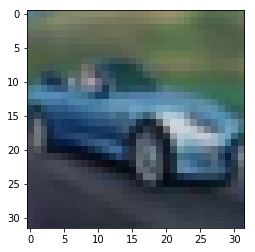

In [6]:
plt.imshow(X[9487])

In [7]:
#Hyperperemeter
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.1
BN_EPSILON  = 0.00002
SAVE_DIR = 'generated_img_CIFAR10_DCGAN/'

GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [8]:
def BuildGenerator(summary=True):
    model = Sequential()
    model.add(Dense(4*4*512, kernel_initializer='glorot_uniform' , input_dim=128))
    model.add(Reshape((4,4,512)))
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(64,  kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh'))
    if summary:
        print("Generator")
        model.summary()
    return model

In [9]:
def BuildDiscriminator(summary=True, spectral_normalization=True):
    if spectral_normalization:
        model = Sequential()
        model.add(ConvSN2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same', input_shape=(32,32,3) ))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Flatten())
        model.add(DenseSN(1,kernel_initializer='glorot_uniform'))
    else:
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same', input_shape=(32,32,3) ))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Flatten())
        model.add(Dense(1,kernel_initializer='glorot_uniform'))
    if summary:
        print('Discriminator')
        print('Spectral Normalization: {}'.format(spectral_normalization))
        model.summary()
    return model

In [10]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [11]:
generator = BuildGenerator()
discriminator = BuildDiscriminator()

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        131136    


In [12]:
Noise_input_for_training_generator = Input(shape=(128,))
Generated_image                    = generator(Noise_input_for_training_generator)
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model(Noise_input_for_training_generator, Discriminator_output)
print("model_for_training_generator")
model_for_training_generator.summary()

model_for_training_generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         3813251   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2935873   
Total params: 6,749,124
Trainable params: 6,748,228
Non-trainable params: 896
_________________________________________________________________


In [13]:
discriminator.trainable = False
model_for_training_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         3813251   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2935873   
Total params: 6,749,124
Trainable params: 3,812,355
Non-trainable params: 2,936,769
_________________________________________________________________


In [14]:
model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=wasserstein_loss)

In [15]:
Real_image                             = Input(shape=(32,32,3))
Noise_input_for_training_discriminator = Input(shape=(128,))
Fake_image                             = generator(Noise_input_for_training_discriminator)
Discriminator_output_for_real          = discriminator(Real_image)
Discriminator_output_for_fake          = discriminator(Fake_image)

model_for_training_discriminator       = Model([Real_image,
                                                Noise_input_for_training_discriminator],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=[wasserstein_loss, wasserstein_loss])
model_for_training_discriminator.summary()

model_for_training_discriminator
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 128)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 32, 32, 3)     3813251     input_3[0][0]                    
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 1)             2935873     input_2[0][0]                    
                                                          

In [16]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y

In [17]:
X = X/255*2-1

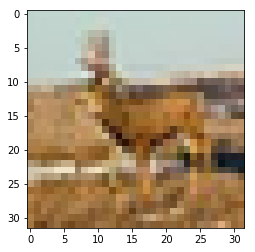

In [18]:
plt.imshow((X[8787]+1)/2)

In [19]:
test_noise = np.random.randn(GENERATE_BATCHSIZE, 128)
W_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, noise],
                                                                                      [real_y, fake_y]))
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(model_for_training_generator.train_on_batch(np.random.randn(BATCHSIZE, 128), real_y))
    
    print('\nepoch time: {}'.format(time()-start_time))
    
    W_real = model_for_training_generator.evaluate(test_noise, real_y)
    print(W_real)
    W_fake = model_for_training_generator.evaluate(test_noise, fake_y)
    print(W_fake)
    W_l = W_real+W_fake
    print('wasserstein_loss: {}'.format(W_l))
    W_loss.append(W_l)
    #Generate image
    generated_image = generator.predict(test_noise)
    generated_image = (generated_image+1)/2
    for i in range(GENERATE_ROW_NUM):
        new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(32*GENERATE_ROW_NUM,32,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 65.86544990539551
32/64 [==============>...............] - ETA: 0s-570.5798645019531
wasserstein_loss: 9.1552734375e-05
plot generated_image
epoch 2 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.417253255844116
32/64 [==============>...............] - ETA: 0s1419.6845703125
wasserstein_loss: 0.0001220703125
plot generated_image
epoch 3 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.60102653503418
32/64 [==============>...............] - ETA: 0s20.736845016479492
wasserstein_loss: 3.814697265625e-06
plot generated_image
epoch 4 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.488672494888306
32/64 [==============>...............] - ETA: 0s467.9406433105469
wasserstein_loss: 9.1552734375e-05
plot generated_image
epoch 5 of 500
number of batches:

epoch 28 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 85.38367366790771
32/64 [==============>...............] - ETA: 0s2414.850341796875
wasserstein_loss: -0.00048828125
plot generated_image
epoch 29 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.76259994506836
32/64 [==============>...............] - ETA: 0s1323.630615234375
wasserstein_loss: -0.00018310546875
plot generated_image
epoch 30 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.481377363204956
32/64 [==============>...............] - ETA: 0s-2133.3224487304688
wasserstein_loss: -6.103515625e-05
plot generated_image
epoch 31 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.35567259788513
32/64 [==============>...............] - ETA: 0s27.123507499694824
wasserstein_loss: 0.0
plot generated_image
epoch 32 of 500
number of batches: 937
936

936/937 [============================>.] - ETA: 0s
epoch time: 63.92101573944092
32/64 [==============>...............] - ETA: 0s509101.25
wasserstein_loss: 0.015625
plot generated_image
epoch 56 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.43449950218201
32/64 [==============>...............] - ETA: 0s113165.30859375
wasserstein_loss: -0.00390625
plot generated_image
epoch 57 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.79249858856201
32/64 [==============>...............] - ETA: 0s19227.8310546875
wasserstein_loss: -0.0009765625
plot generated_image
epoch 58 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.47976851463318
32/64 [==============>...............] - ETA: 0s-25798.8212890625
wasserstein_loss: 0.001953125
plot generated_image
epoch 59 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 6

32/64 [==============>...............] - ETA: 0s-2176.6207885742188
wasserstein_loss: 0.00177001953125
plot generated_image
epoch 83 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.68456506729126
32/64 [==============>...............] - ETA: 0s-104251.68359375
wasserstein_loss: 0.00390625
plot generated_image
epoch 84 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.6310133934021
32/64 [==============>...............] - ETA: 0s-1762311.4375
wasserstein_loss: -0.0625
plot generated_image
epoch 85 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.635666608810425
32/64 [==============>...............] - ETA: 0s21435.5458984375
wasserstein_loss: 0.0009765625
plot generated_image
epoch 86 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.5364727973938
32/64 [==============>...............] - ETA: 0s-676997.

936/937 [============================>.] - ETA: 0s
epoch time: 63.80851912498474
32/64 [==============>...............] - ETA: 0s-2406.2186279296875
wasserstein_loss: -0.0003662109375
plot generated_image
epoch 111 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.73405742645264
32/64 [==============>...............] - ETA: 0s-11256.60693359375
wasserstein_loss: 0.0009765625
plot generated_image
epoch 112 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.636479139328
32/64 [==============>...............] - ETA: 0s-1939063.5
wasserstein_loss: -0.1875
plot generated_image
epoch 113 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.68892693519592
32/64 [==============>...............] - ETA: 0s-18313.0029296875
wasserstein_loss: 0.001953125
plot generated_image
epoch 114 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
e

32/64 [==============>...............] - ETA: 0s9734.142333984375
wasserstein_loss: 0.0009765625
plot generated_image
epoch 138 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.35851645469666
32/64 [==============>...............] - ETA: 0s-3388.6829833984375
wasserstein_loss: 0.0001220703125
plot generated_image
epoch 139 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.29530119895935
32/64 [==============>...............] - ETA: 0s-4461845.25
wasserstein_loss: -0.25
plot generated_image
epoch 140 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.34258890151978
32/64 [==============>...............] - ETA: 0s-24317.576171875
wasserstein_loss: -0.001953125
plot generated_image
epoch 141 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.4493944644928
32/64 [==============>...............] - ETA: 0s-7

936/937 [============================>.] - ETA: 0s
epoch time: 140.2676305770874
32/64 [==============>...............] - ETA: 0s-5193.8775634765625
wasserstein_loss: -0.00103759765625
plot generated_image
epoch 166 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.06949949264526
32/64 [==============>...............] - ETA: 0s-283060.890625
wasserstein_loss: -0.0625
plot generated_image
epoch 167 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.1079249382019
32/64 [==============>...............] - ETA: 0s5143119.75
wasserstein_loss: -0.25
plot generated_image
epoch 168 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.0216999053955
32/64 [==============>...............] - ETA: 0s-1087.3719482421875
wasserstein_loss: 0.0001220703125
plot generated_image
epoch 169 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
ep

32/64 [==============>...............] - ETA: 0s-9200.25244140625
wasserstein_loss: -0.00146484375
plot generated_image
epoch 193 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.28316068649292
32/64 [==============>...............] - ETA: 0s-104511.7734375
wasserstein_loss: 0.0078125
plot generated_image
epoch 194 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.16211676597595
32/64 [==============>...............] - ETA: 0s-354283.609375
wasserstein_loss: -0.046875
plot generated_image
epoch 195 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.21356654167175
32/64 [==============>...............] - ETA: 0s242885.59375
wasserstein_loss: 0.0703125
plot generated_image
epoch 196 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.15337920188904
32/64 [==============>...............] - ETA: 0s-171459.3

936/937 [============================>.] - ETA: 0s
epoch time: 140.59102845191956
32/64 [==============>...............] - ETA: 0s-11752021.0
wasserstein_loss: 1.0
plot generated_image
epoch 221 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.5240979194641
32/64 [==============>...............] - ETA: 0s-32354.7978515625
wasserstein_loss: -0.0029296875
plot generated_image
epoch 222 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.32040071487427
32/64 [==============>...............] - ETA: 0s-580056.0
wasserstein_loss: 0.125
plot generated_image
epoch 223 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.5332272052765
32/64 [==============>...............] - ETA: 0s-50946.1875
wasserstein_loss: -0.0048828125
plot generated_image
epoch 224 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.630981683

epoch 248 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.22690415382385
32/64 [==============>...............] - ETA: 0s4233.4912109375
wasserstein_loss: -0.0003662109375
plot generated_image
epoch 249 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.1159598827362
32/64 [==============>...............] - ETA: 0s-1957649.5625
wasserstein_loss: 0.125
plot generated_image
epoch 250 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.4335994720459
32/64 [==============>...............] - ETA: 0s365557.40625
wasserstein_loss: -0.015625
plot generated_image
epoch 251 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.13378047943115
32/64 [==============>...............] - ETA: 0s-70536.00390625
wasserstein_loss: 0.0078125
plot generated_image
epoch 252 of 500
number of batches: 937
936/937 [===============

epoch 276 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.4914481639862
32/64 [==============>...............] - ETA: 0s-457488.40625
wasserstein_loss: -0.03125
plot generated_image
epoch 277 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.4501600265503
32/64 [==============>...............] - ETA: 0s35653.958984375
wasserstein_loss: -0.009765625
plot generated_image
epoch 278 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.39008045196533
32/64 [==============>...............] - ETA: 0s-4147.4683837890625
wasserstein_loss: -0.006591796875
plot generated_image
epoch 279 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 140.17290210723877
32/64 [==============>...............] - ETA: 0s-1056723.1875
wasserstein_loss: -0.1875
plot generated_image
epoch 280 of 500
number of batches: 937
936/937 [=======

32/64 [==============>...............] - ETA: 0s-122950.9765625
wasserstein_loss: 0.00390625
plot generated_image
epoch 304 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 139.90365266799927
32/64 [==============>...............] - ETA: 0s-240191.015625
wasserstein_loss: 0.015625
plot generated_image
epoch 305 of 500
number of batches: 937
 78/937 [=>............................] - ETA: 127s

KeyboardInterrupt: 

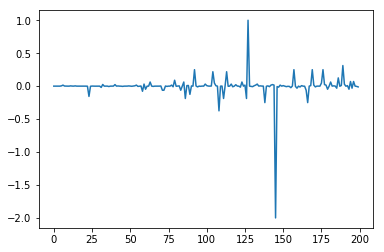

In [21]:
plt.plot(W_loss[
    
])

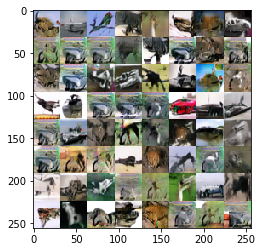

In [25]:
plt.imshow(old)